## Extract LDM Latents

In this notebook, we show how to extract unet latents 

Motivated by [Sparse AutoEncoder](https://github.com/openai/sparse_autoencoder) and [Transformer Lens](https://github.com/TransformerLensOrg/TransformerLens)

In [ ]:
# Import Modules

import functools
import os
import time
from typing import Sequence
import sys
sys.path.append(".") # run maxdiffusion codebase in editable mode
os.environ['HF_HOME']='/nfs_cache/huggingface' # save one copy and share on all hosts
import numpy as np
import matplotlib.pyplot as plt
import flax
import jax
import jax.numpy as jnp
from maxdiffusion.max_utils import (
  create_device_mesh,
  get_dtype,
  get_states,
  device_put_replicated,
  get_flash_block_sizes
)
from maxdiffusion import pyconfig
from absl import app
from maxdiffusion import (
  FlaxStableDiffusionPipeline,
  FlaxDDIMScheduler,
  FlaxUNet2DConditionModel
)

from maxdiffusion.maxdiffusion_utils import rescale_noise_cfg
from flax.linen import partitioning as nn_partitioning
from jax.experimental.compilation_cache import compilation_cache as cc
from jax.sharding import Mesh, PositionalSharding
from maxdiffusion.image_processor import VaeImageProcessor

cc.set_cache_dir(os.path.expanduser("~/jax_cache"))


In [2]:
# Define Functions (capture intermediates in loop_body)
def loop_body(step, args, model, pipeline, prompt_embeds, guidance_scale, guidance_rescale):
    latents, scheduler_state, state, intermediates = args
    latents_input = jnp.concatenate([latents] * 2)

    t = jnp.array(scheduler_state.timesteps, dtype=jnp.int32)[step]
    timestep = jnp.broadcast_to(t, latents_input.shape[0])

    latents_input = pipeline.scheduler.scale_model_input(scheduler_state, latents_input, t)

    model_out, intermediates = model.apply(
        {"params" : state.params},
        jnp.array(latents_input),
        jnp.array(timestep, dtype=jnp.int32),
        encoder_hidden_states=prompt_embeds,
        capture_intermediates=True
    )
    noise_pred = model_out.sample

    noise_pred_uncond, noise_prediction_text = jnp.split(noise_pred, 2, axis=0)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_prediction_text - noise_pred_uncond)

    # Based on 3.4. in https://arxiv.org/pdf/2305.08891.pdf
    noise_pred = rescale_noise_cfg(noise_pred, noise_prediction_text, guidance_rescale=guidance_rescale)

    latents, scheduler_state = pipeline.scheduler.step(scheduler_state, noise_pred, t, latents).to_tuple()

    return latents, scheduler_state, state, intermediates

def tokenize(prompt, tokenizer):
    """Tokenizes prompt."""
    return tokenizer(
        prompt,
        padding="max_length",
        max_length=tokenizer.model_max_length,
        truncation=True,
        return_tensors="np"
    ).input_ids

def get_unet_inputs(rng, config, batch_size, pipeline, params):
    vae_scale_factor = 2 ** (len(pipeline.vae.config.block_out_channels) - 1)
    prompt_ids = [config.prompt] * batch_size
    prompt_ids = tokenize(prompt_ids, pipeline.tokenizer)
    negative_prompt_ids = [config.negative_prompt] * batch_size
    negative_prompt_ids = tokenize(negative_prompt_ids, pipeline.tokenizer)
    guidance_scale = config.guidance_scale
    guidance_rescale = config.guidance_rescale
    num_inference_steps = config.num_inference_steps

    prompt_embeds = pipeline.text_encoder(prompt_ids, params=params["text_encoder"])[0]
    negative_prompt_embeds = pipeline.text_encoder(negative_prompt_ids, params=params["text_encoder"])[0]
    context = jnp.concatenate([negative_prompt_embeds, prompt_embeds])
    guidance_scale = jnp.array([guidance_scale], dtype=jnp.float32)
    guidance_rescale = jnp.array([guidance_rescale], dtype=jnp.float32)

    batch_size = prompt_ids.shape[0]
    latents_shape = (
        batch_size,
        pipeline.unet.config.in_channels,
        config.resolution // vae_scale_factor,
        config.resolution // vae_scale_factor,
    )
    latents = jax.random.normal(rng, shape=latents_shape, dtype=jnp.float32)

    scheduler_state = pipeline.scheduler.set_timesteps(
        params["scheduler"],
        num_inference_steps=num_inference_steps,
        shape=latents.shape
    )
    latents = latents * params["scheduler"].init_noise_sigma

    return latents, context, guidance_scale, guidance_rescale, scheduler_state

def vae_decode(latents, state, pipeline):
    latents = 1 / pipeline.vae.config.scaling_factor * latents
    image = pipeline.vae.apply(
        {"params" : state.params},
        latents,
        method=pipeline.vae.decode
    ).sample
    image = (image / 2 + 0.5).clip(0, 1).transpose(0, 2, 3, 1)
    return image


In [18]:
# Load Configs
argv = 'generate.py maxdiffusion/configs/base21.yml pretrained_model_name_or_path=stabilityai/stable-diffusion-2-1'.split(" ")
pyconfig.initialize(argv) # defines a global variable config in the namespace pyconfig
config = pyconfig.config
print("Pretrained model path:",config.pretrained_model_name_or_path)

Pretrained model path: stabilityai/stable-diffusion-2-1


In [27]:
# Print Configs (optional)
# from pprint import pprint
# pprint(config.get_keys())

## Run LDM Inference in Notebook Environment

In [ ]:
# Expose "run" function in the environment
rng = jax.random.PRNGKey(config.seed)
# Setup Mesh
devices_array = create_device_mesh(config)
mesh = Mesh(devices_array, config.mesh_axes)

batch_size = jax.device_count() 

weight_dtype = get_dtype(config)
flash_block_sizes = get_flash_block_sizes(config)
pipeline, params = FlaxStableDiffusionPipeline.from_pretrained(
    config.pretrained_model_name_or_path,
    from_pt=True,
    # revision='main',
    # dtype=jnp.bfloat16,
    safety_checker=None,
    feature_extractor=None,
    split_head_dim=config.split_head_dim,
    norm_num_groups=config.norm_num_groups,
    attention_kernel=config.attention,
    flash_block_sizes=flash_block_sizes,
    mesh=mesh
)
################
# reload from unet flax checkpoint (Optional)
# unet, unet_params = FlaxUNet2DConditionModel.from_pretrained(
#         "/home/evergreen/nfs_share/nfs_share/di-f-fu-sion/sd-model-finetuned/pokemon-sd2/checkpoints/UNET-latest",
#         from_pt=True,
#         revision='fp16',
#         dtype=jnp.bfloat16,
#         split_head_dim=config.split_head_dim,
#         norm_num_groups=config.norm_num_groups,
#         attention_kernel=config.attention,
#         flash_block_sizes=flash_block_sizes,
#         mesh=mesh
#     )
# params["unet"] = unet_params
# pipeline.unet = unet
################
scheduler, scheduler_state = FlaxDDIMScheduler.from_pretrained(
    config.pretrained_model_name_or_path, revision=config.revision, subfolder="scheduler", dtype=jnp.float32
)
pipeline.scheduler = scheduler
params = jax.tree_util.tree_map(lambda x: x.astype(weight_dtype), params)
params["scheduler"] = scheduler_state

# Text encoder params
sharding = PositionalSharding(mesh.devices).replicate()
partial_device_put_replicated = functools.partial(device_put_replicated, sharding=sharding)
params["text_encoder"] = jax.tree_util.tree_map(partial_device_put_replicated, params["text_encoder"])

(unet_state,
    unet_state_mesh_shardings,
    vae_state,
    vae_state_mesh_shardings) = get_states(mesh, None, rng, config, pipeline, params["unet"], params["vae"], training=False)
del params["vae"]
del params["unet"]

def run_inference(unet_state, vae_state, params, rng, config, batch_size, pipeline):

    (latents,
    context,
    guidance_scale,
    guidance_rescale,
    scheduler_state) = get_unet_inputs(rng, config, batch_size, pipeline, params)

    loop_body_p = functools.partial(loop_body, model=pipeline.unet,
                                    pipeline=pipeline,
                                    prompt_embeds=context,
                                    guidance_scale=guidance_scale,
                                    guidance_rescale=guidance_rescale)

    vae_decode_p = functools.partial(vae_decode, pipeline=pipeline)
    _, _, _, intermediates = loop_body_p(step=0,args=(latents, scheduler_state,unet_state, None)) # dry run to get intermediates pytree

    with mesh, nn_partitioning.axis_rules(config.logical_axis_rules):
        latents, _, _, intermediates = jax.lax.fori_loop(0, config.num_inference_steps,
                                        loop_body_p, (latents, scheduler_state, unet_state, intermediates))
        image = vae_decode_p(latents, vae_state)
        return image, latents, context, intermediates

p_run_inference = jax.jit(
    functools.partial(run_inference, rng=rng, config=config, batch_size=batch_size, pipeline=pipeline),
    in_shardings=(unet_state_mesh_shardings, vae_state_mesh_shardings, None),
    out_shardings=None
)

print("compilation start...")
s = time.time()
images, latents, context, intermediates = p_run_inference(unet_state, vae_state, params)
images.block_until_ready()
print("compile time: ", (time.time() - s))

s = time.time()
images, latents, context, intermediates = p_run_inference(unet_state, vae_state, params)
images.block_until_ready()
print("inference time: ",(time.time() - s))
numpy_images = np.array(images)
images = VaeImageProcessor.numpy_to_pil(numpy_images)
# for i, image in enumerate(images):
#     image.save(f"image_{i}.png")
intermediates = jax.device_get(flax.jax_utils.unreplicate(intermediates['intermediates']))

In [53]:
# Get an impression of the module surgery (Optional)
print(intermediates.keys())
jax.tree.map(lambda x: x.shape,intermediates)

[x.shape for x in (intermediates['conv_in']['__call__'][0],
intermediates['down_blocks_0']['__call__'][0][0],
intermediates['down_blocks_1']['__call__'][0][0],
intermediates['down_blocks_2']['__call__'][0][0],
intermediates['down_blocks_3']['__call__'][0][0],
intermediates['up_blocks_0']['__call__'][0],
intermediates['up_blocks_1']['__call__'][0],
intermediates['up_blocks_2']['__call__'][0],
intermediates['up_blocks_3']['__call__'][0],
intermediates['conv_out']['__call__'][0],)]

dict_keys(['__call__', 'conv_in', 'conv_norm_out', 'conv_out', 'down_blocks_0', 'down_blocks_1', 'down_blocks_2', 'down_blocks_3', 'mid_block', 'time_embedding', 'time_proj', 'up_blocks_0', 'up_blocks_1', 'up_blocks_2', 'up_blocks_3'])


[(96, 96, 320),
 (48, 48, 320),
 (24, 24, 640),
 (12, 12, 1280),
 (12, 12, 1280),
 (24, 24, 1280),
 (48, 48, 1280),
 (96, 96, 640),
 (96, 96, 320),
 (96, 96, 4)]

{'conv_in': {'bias': (320,), 'kernel': (3, 3, 4, 320)},
 'conv_norm_out': {'bias': (320,), 'scale': (320,)},
 'conv_out': {'bias': (4,), 'kernel': (3, 3, 320, 4)},
 'down_blocks_0': {'attentions_0': {'norm': {'bias': (320,), 'scale': (320,)},
   'proj_in': {'bias': (320,), 'kernel': (320, 320)},
   'proj_out': {'bias': (320,), 'kernel': (320, 320)},
   'transformer_blocks_0': {'attn1': {'to_k': {'kernel': (320, 320)},
     'to_out_0': {'bias': (320,), 'kernel': (320, 320)},
     'to_q': {'kernel': (320, 320)},
     'to_v': {'kernel': (320, 320)}},
    'attn2': {'to_k': {'kernel': (1024, 320)},
     'to_out_0': {'bias': (320,), 'kernel': (320, 320)},
     'to_q': {'kernel': (320, 320)},
     'to_v': {'kernel': (1024, 320)}},
    'ff': {'net_0': {'proj': {'bias': (2560,), 'kernel': (320, 2560)}},
     'net_2': {'bias': (320,), 'kernel': (1280, 320)}},
    'norm1': {'bias': (320,), 'scale': (320,)},
    'norm2': {'bias': (320,), 'scale': (320,)},
    'norm3': {'bias': (320,), 'scale': (32

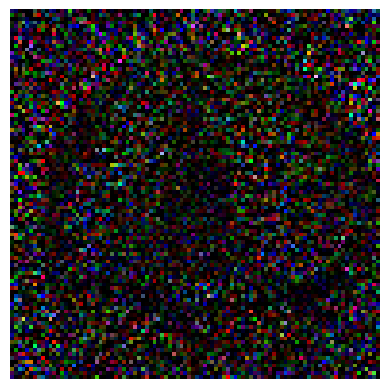

In [57]:
# Print model structure (Optional)
plt.imshow(intermediates['conv_out']['__call__'][0][:,:,:3]);plt.axis('off')
jax.tree.map(lambda x: x.shape,unet_state.params)

Histogram of Some Hidden States


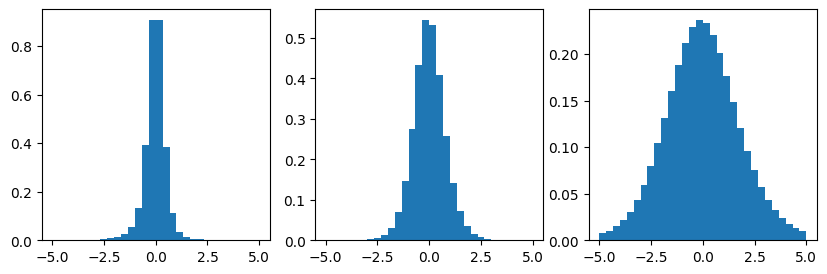

In [22]:
# Plot several states
plt.figure(figsize=(10,3))

states = intermediates['down_blocks_0']['__call__'][0][1]
def hist(w):
    plt.hist(w.flatten(),density=True,bins=30,range=[-5,5])

for i, w in enumerate(states):
    plt.subplot(1,len(states),i+1)
    hist(w)
    
print("Histogram of Some Hidden States")

In [23]:
# Reproduce "context" variable to make it clear... 
prompt_ids = tokenize([config.prompt], pipeline.tokenizer)
prompt_ids

array([[49406,   320,  7823,  3540,   530,   518,  3694,   539,   320,
         4167,   267, 12421,  3610, 49407,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0]])

In [24]:
# Language tokens
c = pipeline.text_encoder(prompt_ids, params=params["text_encoder"])[0]
c.shape

(1, 77, 1024)

Covariance Matrix of Language Tokens and Zoom-In of Non-Empty Words


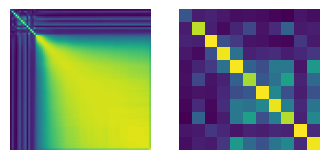

In [25]:
# Covariance Matrix
M = jnp.einsum('abc,dec->be',c,c)
plt.figure(figsize=(4,2))
plt.subplot(121)
plt.imshow(M);plt.axis('off')
plt.subplot(122)
plt.imshow(M[:11,:11]);plt.axis('off')
print("Covariance Matrix of Language Tokens and Zoom-In of Non-Empty Words")

Covariant Matrices of Linear Embeddings in Some Layers. They are equivalent modulo SL(320) and we find some redundancies... Excercise: find more using intermediates!


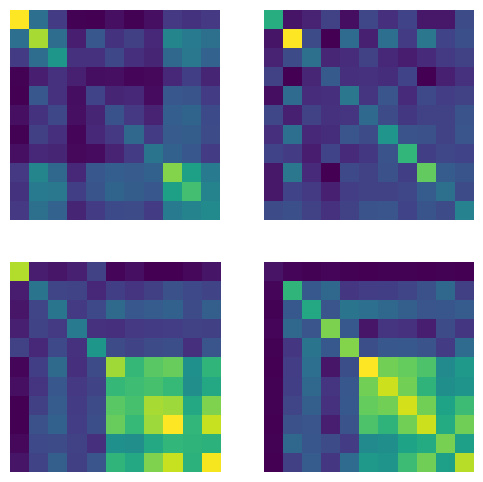

In [26]:
# Covariance of Attention KVs
attns = intermediates['down_blocks_0']['attentions_0']['transformer_blocks_0']
k1 = attns['attn1']['to_k']['__call__'][0]
v1 = attns['attn1']['to_v']['__call__'][0]
k2 = attns['attn2']['to_k']['__call__'][0]
v2 = attns['attn2']['to_v']['__call__'][0]
cov = lambda x,y: jnp.einsum('abc,dec->be',x,y).astype(jnp.float32)
Mk1 = cov(k1,k1)
Mv1 = cov(v1,v1)
Mk2 = cov(k2,k2)
Mv2 = cov(v2,v2)
plt.figure(figsize=(6,6))
plt.subplot(221)
plt.imshow(Mk1[:11,:11]);plt.axis('off')
plt.subplot(222)
plt.imshow(Mv1[:11,:11]);plt.axis('off')

plt.subplot(223)
plt.imshow(Mk2[:11,:11]);plt.axis('off')
plt.subplot(224)
plt.imshow(Mv2[:11,:11]);plt.axis('off')
print("Covariant Matrices of Linear Embeddings in Some Layers. They are equivalent modulo SL(320) and we find some redundancies... Excercise: find more using intermediates!")

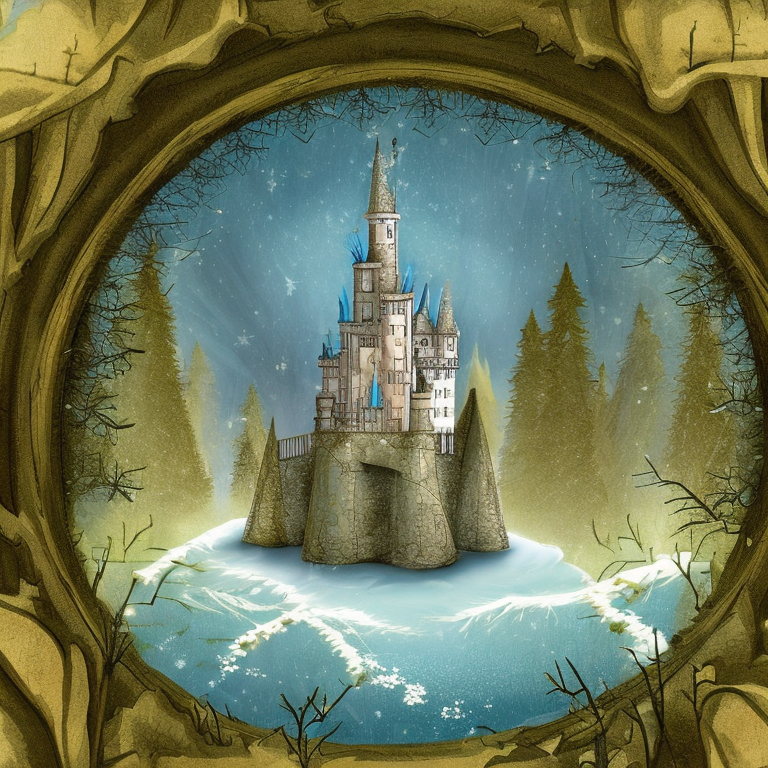

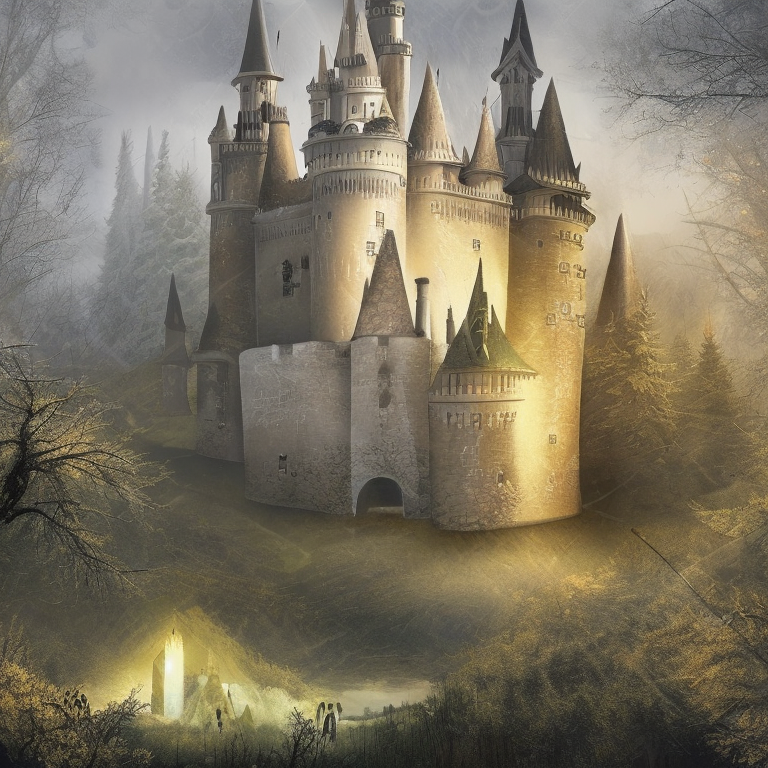

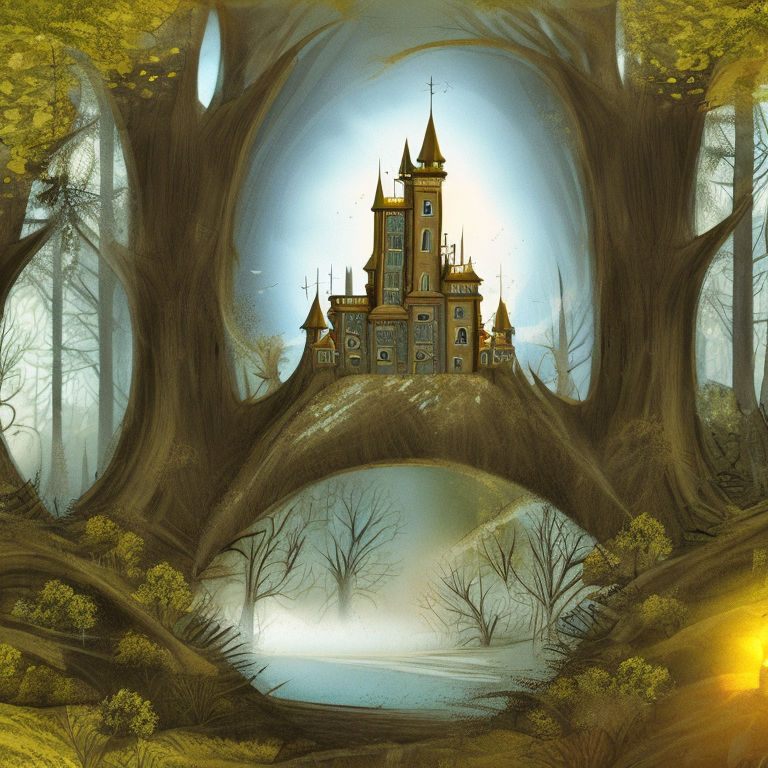

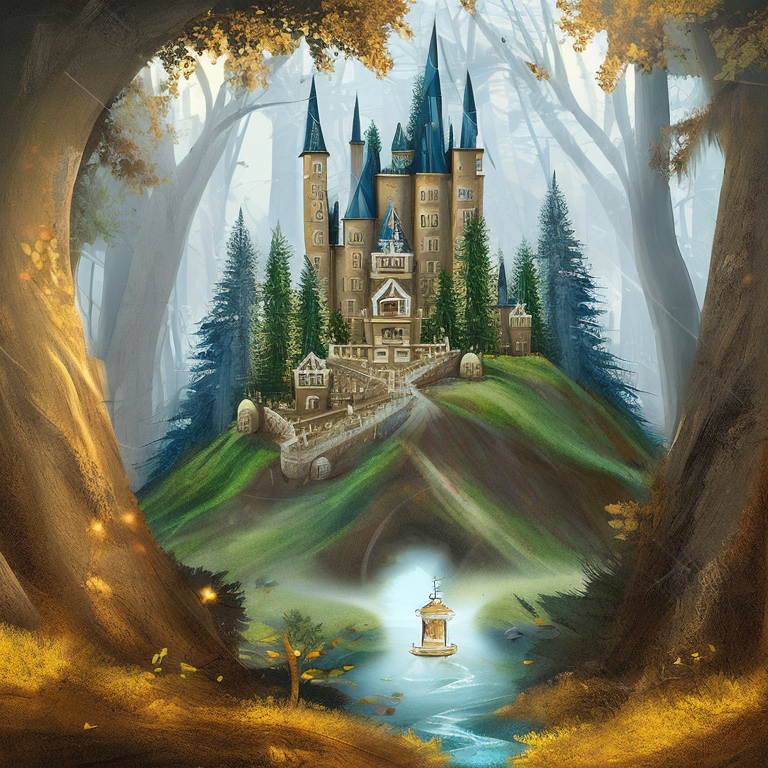

Lastly we show the generated images. Prompt: A magical castle in the middle of a forest, artistic drawing


In [21]:
[display(image) for image in images]
print("Lastly we show the generated images. Prompt:",config.prompt)